<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 

<a href="http://wikistat.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/wikistat.jpg" style="max-width: 250px; display: inline"  alt="Wikistat"/></a>

<a href="http://www.math.univ-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo_imt.jpg" style="float:right; max-width: 200px; display: inline" alt="IMT"/> </a>
</center>

# [Ateliers: Technologies des grosses data](https://github.com/wikistat/Ateliers-Big-Data)

# [Reconnaissance d'Activité Humaine](https://github.com/wikistat/Ateliers-Big-Data/5-HumanActivityRecognition) ([*HAR*](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones)) en <a href="https://www.python.org/"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Python_logo_and_wordmark.svg/390px-Python_logo_and_wordmark.svg.png" style="max-width: 120px; display: inline" alt="Python"/></a> 
##  Seconde partie:  étude des signaux bruts - Exploration et Apprentissage (profond) des signaux bruts  avec <a href="https://keras.io/"><img src="https://s3.amazonaws.com/keras.io/img/keras-logo-2018-large-1200.png" style="max-width: 100px; display: inline" alt="Keras"/></a>



##  1 Introduction
### 1.1  Contexte
Les données sont issues de la communauté qui vise la reconnaissance d'activités humaines (*Human activity recognition, HAR*) à partir d’enregistrements, par exemple du gyroscope et de l'accéléromètre d'un smartphone, objet connecté précurseur et dont la fonctionnalité de téléphonie devient très secondaire.
Voir à ce propos l'[article](https://www.elen.ucl.ac.be/Proceedings/esann/esannpdf/es2013-11.pdf) relatant un colloque de 2013.  

Les données publiques disponibles et largement étudiées ont été acquises, décrites et analysées par [Anguita et al. (2013)]().
Elles sont accessibles sur le [dépôt](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) de l'University California Irvine (UCI) consacré à l'apprentissage machine ainsi que sur le site *Kaggle*.

L'archive contient les données brutes: accélérations en x, y, et z, chacun de 128 colonnes. D'autres fichiers en y soustrayant la gravité naturelle ainsi que les accélérations angulaires en x, y, et z soit en tout 9 fichiers. Mais 6 utiles avec 6*128=768 mesures.

C'est sur ces données brutes que nous allons appliquer des méthodes d'apprentissage

Les méthodes d'apprentissage sont appliquées sur ces données brutes, sans calculs préliminaires de caractéristiques (*features*).

### 1.2 Objectifs
Cette deuxième étape s'intéresse aux données brutes. Est-il possible d'économiser le travail préliminaire de définition des variables métier en utilisant par exemple les ressources de décompositions systématiques sur une base d'ondelette ou un algorihtme d'apprentissage profond? L'enjeu est important, le calcul en temps réel des variables métier consomme beaucoup d'énergie et l'objectif serait de pouvoir embarquer (faire porter) un système économe défini par exemple par un réseau de neurones après son apprentissage.

Comme pour les données métier, l'étude commence par une exploration: affichage et visualisation des données, réduction de dimension.

### 1.3 Travail à réaliser
**Attention l'accès à un environnement *GPU* est très vivement conseillé voire indispensable.**
- Modélisation, prévision de l'échantillon test par
   - Régression logistique (`Scikit-learn`)
   - Apprentissage profond en utilisant `Keras` 
       - MLP sur signaux "applatis"
       - MLP sur signaux mutlidimensionelles
       - LSTM
       - 1D Convolution
       - 2D Convolution
   
- Ajouter à ce calepin: 
    - Application des méthodes d'apprentissage classique ou non sur les coefficients des décompositions des signaux en ondelettes
    - optimisation des paramètres des différentes méthodes.
    - Améliorer l'architexture des réseaux?


### 1.4 Librairies

In [61]:
import pandas as pd
import numpy as np
import os
import time
import copy
import random
import itertools

#Utils Sklearn
import sklearn.linear_model as lm
from sklearn.metrics import confusion_matrix

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()
sb.set_style("darkgrid", {"axes.facecolor": ".9"})

import sklearn.decomposition as sdec 
import sklearn.preprocessing as sprep
import sklearn.discriminant_analysis as sda

from statsmodels.robust import mad

# Hierarchical clustering
import scipy.cluster.hierarchy as sch
#Wavelet
import pywt
# LOF
import sklearn.neighbors as sn
# Isolation Forest
import sklearn.ensemble as se
import sklearn.decomposition as sd
import sklearn.preprocessing as sp

# Plot et Display
from IPython.display import display

import pandas as pd
import numpy as np
import os
import time
import copy
import random
import itertools

#Utils Sklearn
import sklearn.linear_model as lm
from sklearn.metrics import confusion_matrix

%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()

# DEEP LEARING
import tensorflow as tf
np.random.seed(42)
tf.set_random_seed(42)

# for reproducibility
# https://github.com/fchollet/keras/issues/2280
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

import keras.models as km 
import keras.layers as kl 
import keras.layers.core as klc

Using TensorFlow backend.


## 2 Prise en charge des données
### 2.1 Source

Les données sont celles originales du dépôt de l'[UCI](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Elle peuvent être téléchargées en cliquant [ici](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip).

Elles contiennent deux jeux de dimensions différentes, chacun partagé en apprentissage et test.

1. Multidimensionel: un individus est constitué de 9 Séries Temporelles de *dimensions* $(N, 128, 9)$
2. Unidimensionnel: Les 9 Séries Temporelles sont concaténées pour constituer un vecteur de 128*9 = 1152 variables de *dimensions* $(N, 1152)*
        
Deux objets différents sont construits pour définir la variable $Y$ réponse car les librairies `Scikit-learn` et `Keras` prennent en compte des structures différentes: 
    
1. `Scikit-Learn`  Un vecteur de dimension $(N, 1)$ avec, pour chaque individu le numéro du label de l'activité de 0 à 5.
2. `Keras` Une matrice de dimension $(N, 6)$ des indicatrices (0 ou 1) des modalités de $Y$.

### 2.2 Structurer les données
Définir le chemin d'accès aux données puis les fonctions utiles.

In [6]:
DATADIR_UCI = './UCI HAR Dataset'
SIGNALS = [ "body_acc_x", "body_acc_y", "body_acc_z", "body_gyro_x", "body_gyro_y", "body_gyro_z", "total_acc_x", "total_acc_y", "total_acc_z"]

def my_read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

def load_signal(data_dir, subset, signal):
    filename = f'{data_dir}/{subset}/Inertial Signals/{signal}_{subset}.txt'
    x = my_read_csv(filename).as_matrix()
    return x 

def load_signals(data_dir, subset, flatten = False):
    signals_data = []
    for signal in SIGNALS:
        signals_data.append(load_signal(data_dir, subset, signal)) 
    
    if flatten :
        X = np.hstack(signals_data)
    else:
        X = np.transpose(signals_data, (1, 2, 0))
        
    return X 

def load_y(data_dir, subset, dummies = False):
    filename = f'{data_dir}/{subset}/y_{subset}.txt'
    y = my_read_csv(filename)[0]
    
    
    if dummies:
        Y = pd.get_dummies(y).as_matrix()
    else:
        Y = y.as_matrix()
    
    return Y

Lecture des données

In [7]:
#Multidimensional Data
X_train, X_test = load_signals(DATADIR_UCI, 'train'), load_signals(DATADIR_UCI, 'test')
# Flattened Data
X_train_flatten, X_test_flatten = load_signals(DATADIR_UCI, 'train', flatten=True), load_signals(DATADIR_UCI, 'test', flatten=True)

# Label Y
Y_train_label, Y_test_label = load_y(DATADIR_UCI, 'train', dummies = False), load_y(DATADIR_UCI, 'test', dummies = False)
#Dummies Y (For Keras)
Y_train_dummies, Y_test_dummies = load_y(DATADIR_UCI, 'train', dummies = True), load_y(DATADIR_UCI, 'test', dummies = True)

N_train = X_train.shape[0]
N_test = X_test.shape[0]

Vérification des dimensions

In [8]:
print("Dimension")
print("Données Multidimensionelles, : " + str(X_train.shape))
print("Données Unimensionelles, : " + str(X_train_flatten.shape))
print("Vecteur réponse (scikit-learn) : " + str(Y_train_label.shape))
print("Matrice réponse(Keras) : " + str(Y_train_dummies.shape))

Dimension
Données Multidimensionelles, : (7352, 128, 9)
Données Unimensionelles, : (7352, 1152)
Vecteur réponse (scikit-learn) : (7352,)
Matrice réponse(Keras) : (7352, 6)


## 3 Visualisations
### 3.1 Fonctions utiles

In [39]:
CMAP = plt.get_cmap("Accent")
SIGNALS = ["body_acc x", "body_acc y", "body_acc z", 
                "body_gyro x", "body_gyro y", "body_gyro z", 
               "total_acc x", "total_acc y", "total_acc z"] 


ACTIVITY_DIC = {1 : "WALKING",
2 : "WALKING UPSTAIRS",
3 : "WALKING DOWNSTAIRS",
4 : "SITTING",
5 : "STANDING",
6 : "LAYING"}

COLOR_DIC = {1 : "black", 2: "red", 3 : "pink", 4: "orange", 5:'blue', 6:"green"}

def plot_one_axe(X, fig, ax, sample_to_plot, cmap):
    for act,Xgb in X.groupby("Activity"):
        Xgb_first_values = Xgb.values[:sample_to_plot,:-1]
        x = Xgb_first_values[0]
        ax.plot(x, linewidth=1, color=cmap(act-1), label = label_dic[act])
        for x in Xgb_first_values[1:]:
            ax.plot(x, linewidth=1, color=cmap(act-1))

            
def plot_one_axe_shuffle(X, fig, ax, sample_to_plot, cmap):
    plot_data = []
    for act,Xgb in X.groupby("Activity"):
        Xgb_first_values = Xgb.values[:sample_to_plot,:-1]
        x = Xgb_first_values[0]
        ax.plot(x, linewidth=1, color=cmap(act-1), label = label_dic[act])
        for x in Xgb_first_values[1:]:
            plot_data.append([x,cmap(act-1)])
    random.shuffle(plot_data)
    for x,color in plot_data:
        ax.plot(x, linewidth=1, color=color)

### 3.2 Tous les signaux

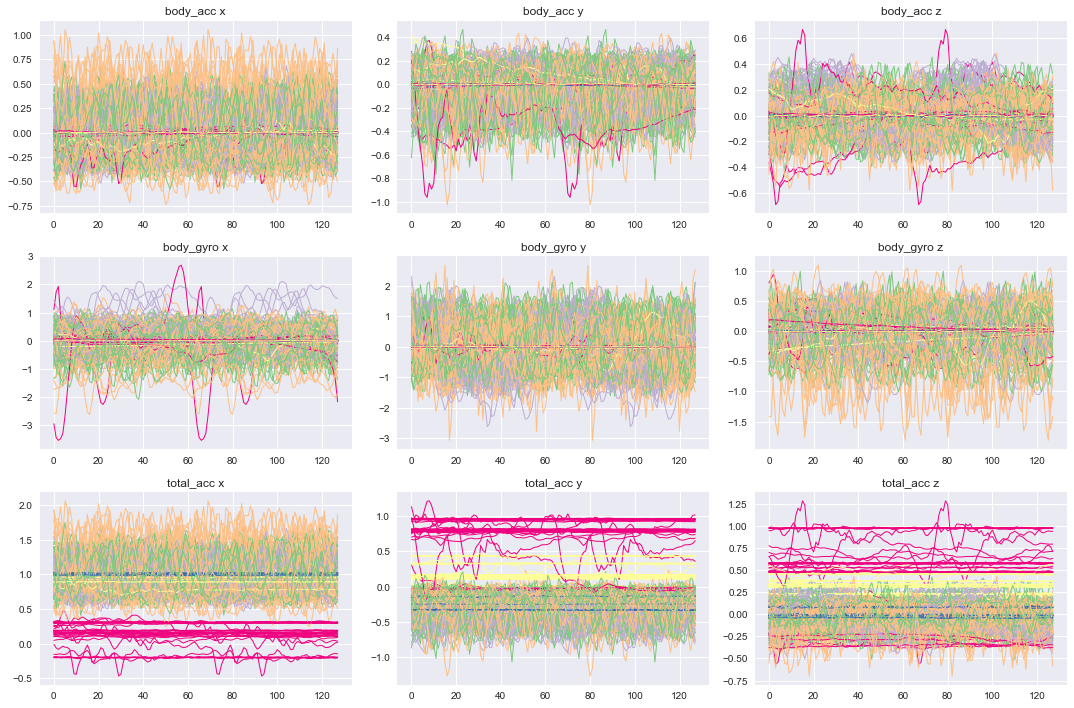

In [10]:
sample_to_plot = 50
index_per_act = [list(zip(np.repeat(act, sample_to_plot), np.where(Y_train_label==act)[0][:sample_to_plot])) for act in range(1,7)]
index_to_plot = list(itertools.chain.from_iterable(index_per_act))
random.shuffle(index_to_plot)

fig = plt.figure(figsize=(15,10))
for isignal in range(9):
    ax = fig.add_subplot(3,3,isignal+1)
    for act , i in index_to_plot:
        ax.plot(range(128), X_train[i,:,isignal],color=CMAP(act-1), linewidth=1)
        ax.set_title(SIGNALS[isignal])
plt.tight_layout()

### 3.3 Par signal 

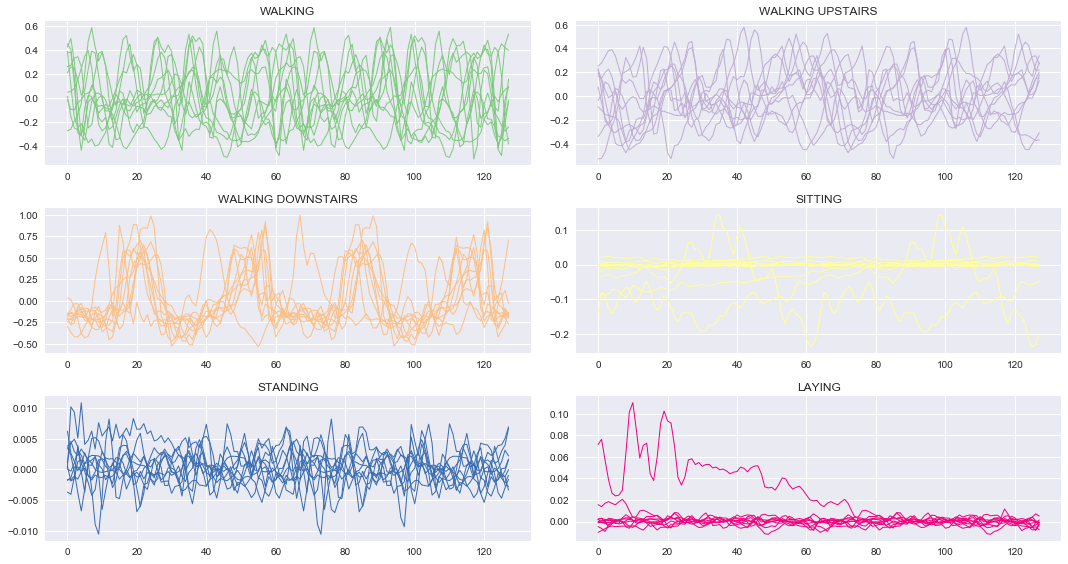

In [11]:
sample_to_plot = 10
isignal = 1
index_per_act_dict = dict([(act, np.where(Y_train_label==act)[0][:sample_to_plot]) for act in range(1,7)])


fig = plt.figure(figsize=(15,8), num=SIGNALS[isignal])
for act , index in index_per_act_dict.items():
    ax = fig.add_subplot(3,2,act)
    for x in X_train[index]:
        ax.plot(range(128), x[:,0],color=CMAP(act-1), linewidth=1)
    ax.set_title(ACTIVITY_DIC[act])
plt.tight_layout()

**Q** Observer l'un des signaux, par exemple `Walking upstairs`. Qu'est ce qui fait que, pour ces signaux ou courbes, une métrique euclidienne classique ($L_2$) est inopérante? 

**Q** Corrélativement pourquoi est-il intéressant de décomposer un signal dans le domaine des fréquances?

In [12]:
def plot_pca(X_R, ytrain, fig, ax, nbc, nbc2, label_dic=ACTIVITY_DIC, cmaps = plt.get_cmap("Accent")
):
    for i in range(6):
        xs = X_R[ytrain==i+1,nbc-1]
        ys = X_R[ytrain==i+1, nbc2-1]
        label = label_dic[i+1]
        color = cmaps(i)
        ax.scatter(xs, ys, color=color, alpha=.8, s=10, label=label)
        ax.set_xlabel("PC%d : %.2f %%" %(nbc,pca.explained_variance_ratio_[nbc-1]*100), fontsize=15)
        ax.set_ylabel("PC%d : %.2f %%" %(nbc2,pca.explained_variance_ratio_[nbc2-1]*100), fontsize=15)


## 4 Analyse en composantes principales
Les ACP ne sont pas réduites. Refaire les calculs après réduction des variables : signaux.

### 4.1 Sur un Signal

In [13]:
pca = sdec.PCA()
isignal = 4
signal = SIGNALS[isignal]
print("ACP Sur signal : " +signal)
X_r = pca.fit_transform(X_train[:,:,isignal])

ACP Sur signal : body_gyro y


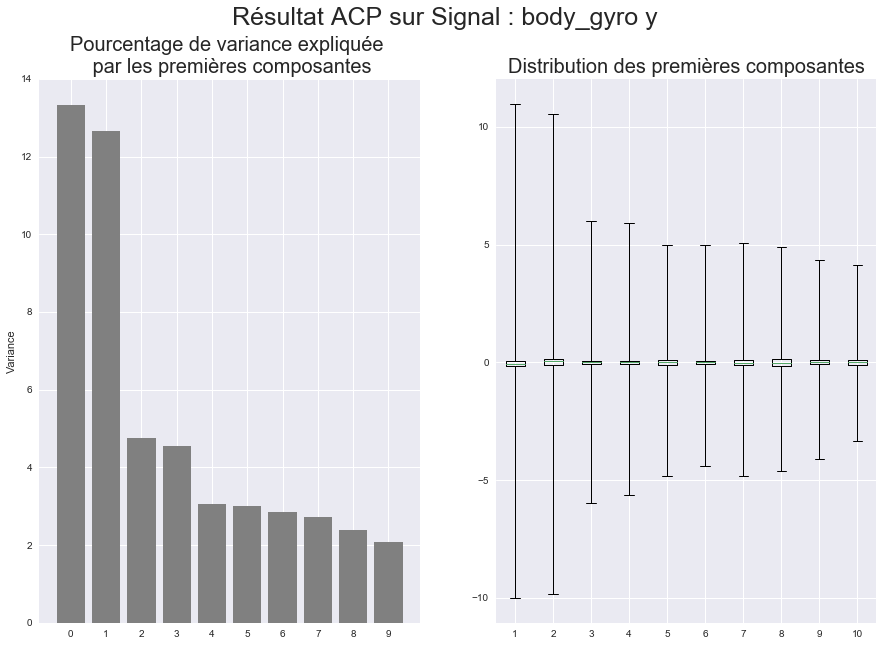

In [14]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,2,1)
ax.bar(range(10), pca.explained_variance_ratio_[:10]*100, align='center',
        color='grey', ecolor='black')
ax.set_xticks(range(10))
ax.set_ylabel("Variance")
ax.set_title("", fontsize=35)
ax.set_title("Pourcentage de variance expliquée \n par les premières composantes", fontsize=20)

ax = fig.add_subplot(1,2,2)
box=ax.boxplot(X_r[:,0:10],whis=100)
ax.set_title("Distribution des premières composantes", fontsize=20)

fig.suptitle("Résultat ACP sur Signal : " + signal, fontsize=25)

**Attetnion**: les diagrammes boîtes sont très perturbés pas les distributions des composantes avec une très forte concentration autour de 0 et énormément de valeurs atypiques. D'où l'utilisation du paramètre `whis=100` pour rallonger les moustaches.

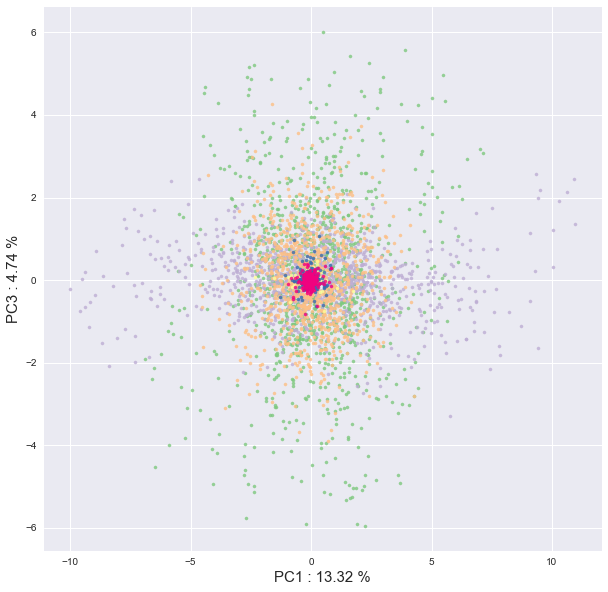

In [15]:
fig = plt.figure(figsize=(10,10), )
ax = fig.add_subplot(1,1,1)
plot_pca(X_r, Y_train_label,fig ,ax ,1 ,3)

### 4.2 Sur tous les signaux

In [16]:
pca = sdec.PCA()
print("ACP Sur tous les signaux")
X_r = pca.fit_transform(X_train_flatten)

ACP Sur tous les signaux


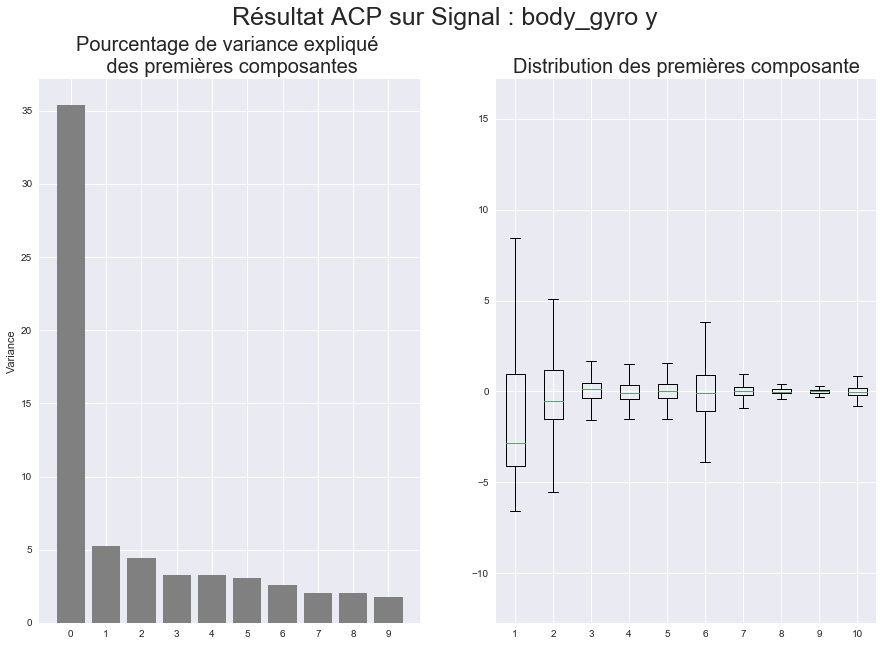

In [17]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,2,1)
ax.bar(range(10), pca.explained_variance_ratio_[:10]*100, align='center',
        color='grey', ecolor='black')
ax.set_xticks(range(10))
ax.set_ylabel("Variance")
ax.set_title("", fontsize=35)
ax.set_title("Pourcentage de variance expliqué \n des premières composantes", fontsize=20)

ax = fig.add_subplot(1,2,2)
box=ax.boxplot(X_r[:,0:10])
ax.set_title("Distribution des premières composante", fontsize=20)

fig.suptitle("Résultat ACP sur Signal : " + signal, fontsize=25)

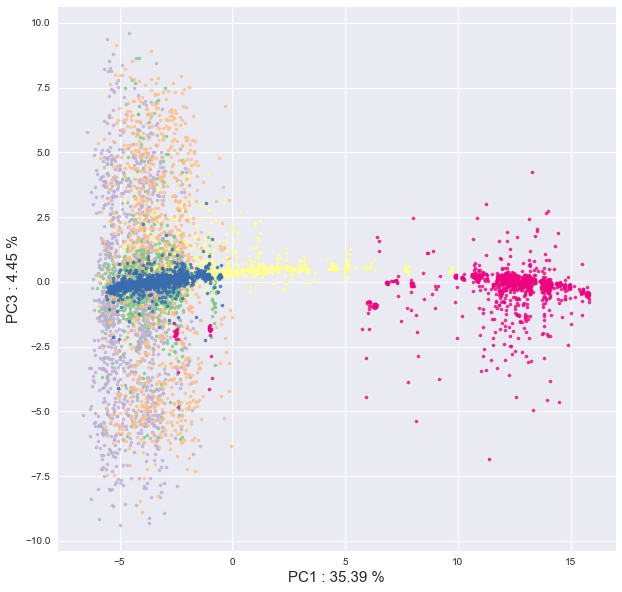

In [18]:
fig = plt.figure(figsize=(10,10), )
ax = fig.add_subplot(1,1,1)
plot_pca(X_r, Y_train_label,fig ,ax ,1 ,3)

## 5 Analyse factorielle discriminante

### 5.1 Sur un signal

LDA Sur signal : body_acc x


C:\Program Files\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


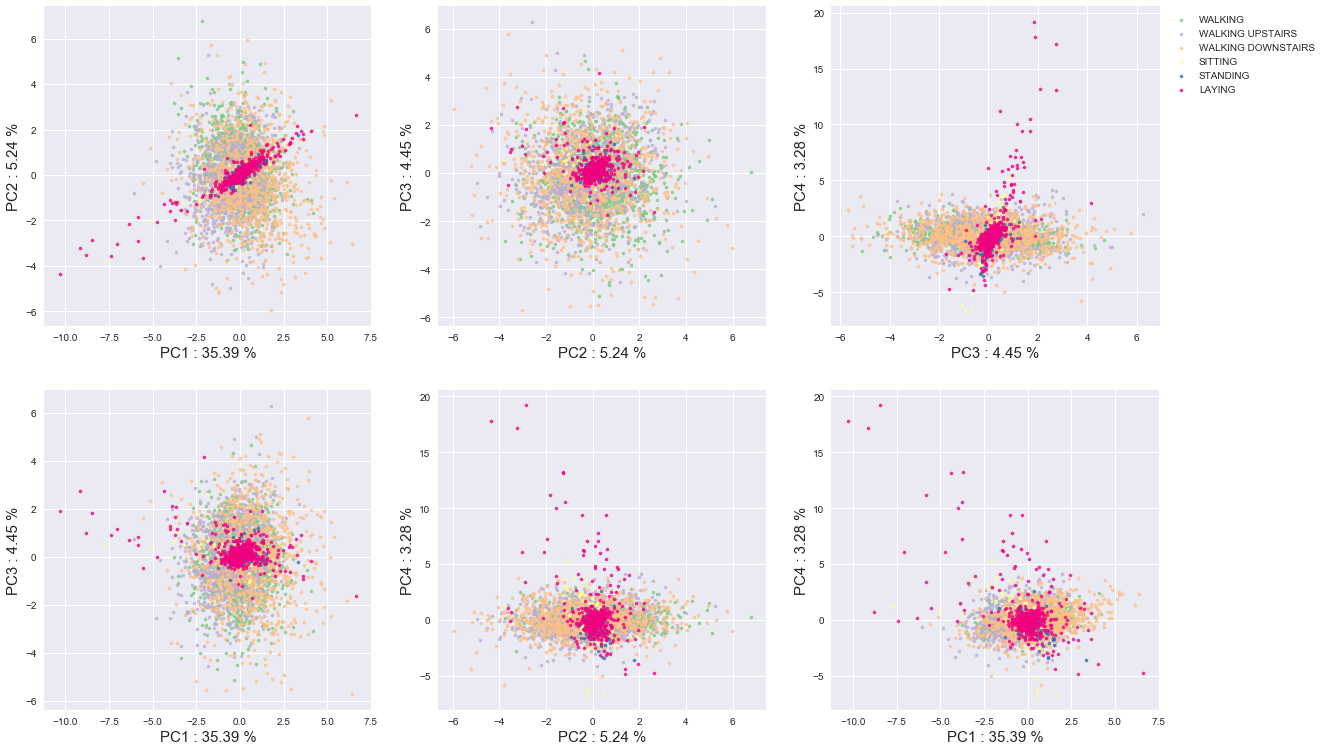

In [19]:
isignal = 0
signal = SIGNALS[isignal]
print("LDA Sur signal : " +signal)

method = sda.LinearDiscriminantAnalysis() 
lda=method.fit(X_train[:,:,isignal],Y_train_label)
X_r2=lda.transform(X_train[:,:,isignal])

fig = plt.figure(figsize= (20,20))
count = 0
for count,(nbc, nbc2)in enumerate([(1,2), (2,3), (3,4), (1,3), (2,4), (1,4)]) :
    ax = fig.add_subplot(3,3,count+1)
    plot_pca(X_r2, Y_train_label , fig,ax,nbc,nbc2)
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 2.2))
plt.show()

### 5.2  Sur tous les signaux

LDA Sur tous les signaux


C:\Program Files\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


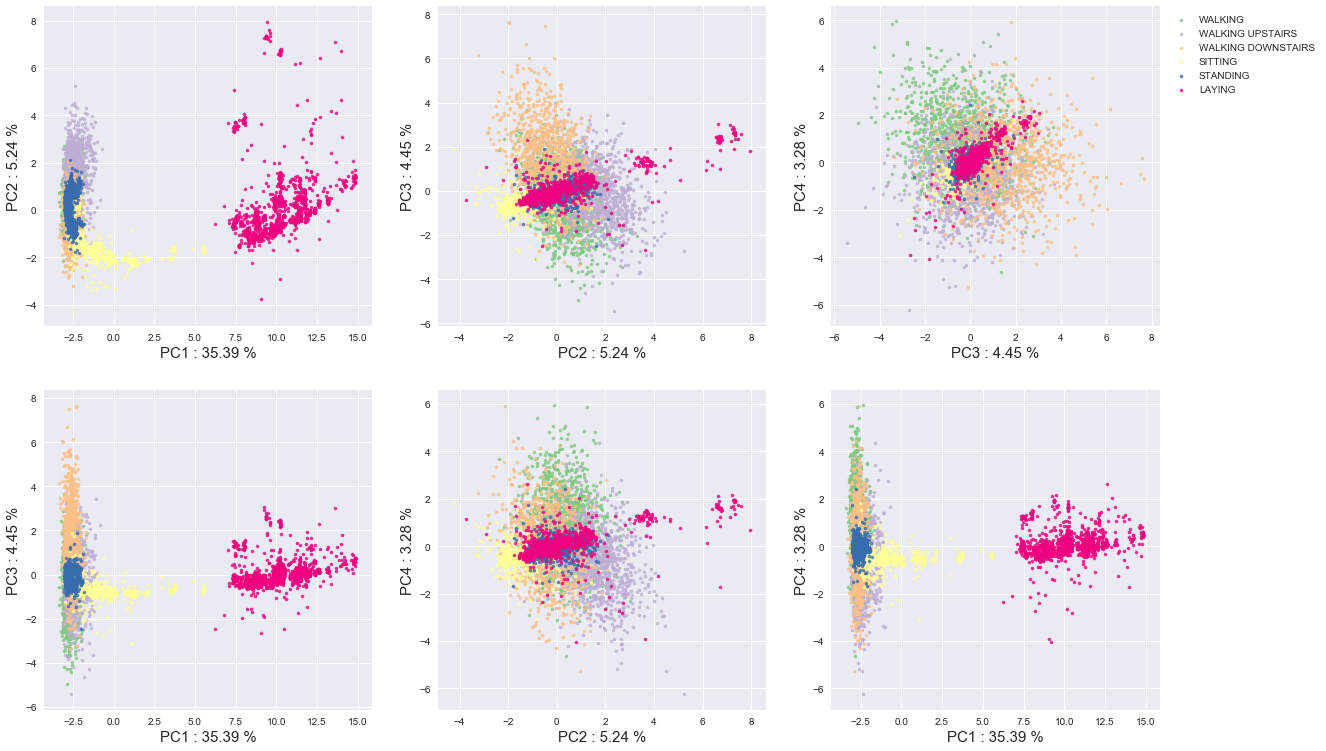

In [20]:
print("LDA Sur tous les signaux")

method = sda.LinearDiscriminantAnalysis() 
lda=method.fit(X_train_flatten,Y_train_label)
X_r2=lda.transform(X_train_flatten)

fig = plt.figure(figsize= (20,20))
count = 0
for count,(nbc, nbc2)in enumerate([(1,2), (2,3), (3,4), (1,3), (2,4), (1,4)]) :
    ax = fig.add_subplot(3,3,count+1)
    plot_pca(X_r2, Y_train_label , fig,ax,nbc,nbc2)
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 2.2))
plt.show()

## Coefficients dans une base d'ondelettes

In [34]:
wf = "haar"

Coeff = []
TCoeff = []
for x in X_train_flatten:
    #Apply wabvelet decomposition
    coeffs = pywt.wavedec(x,wf,level=8)
    coeffs_flatten = np.hstack(coeffs)
    Coeff.append(coeffs_flatten)
    # Compute universal Threshold http://jseabold.net/blog/2012/02/23/wavelet-regression-in-python/
    sigma = mad(coeffs[-1])
    uthresh = sigma*np.sqrt(2*np.log(256))
    # Apply Threshold on 4 fist level
    coeffs_thresh = [pywt.threshold(c, uthresh, mode="hard") if i<=3 else c for i,c in enumerate(coeffs[::-1])]
    coeffs_thresh_flatten = np.hstack(coeffs_thresh[::-1])
    TCoeff.append(coeffs_thresh_flatten)
    
Coeff = np.array(Coeff)
TCoeff = np.array(TCoeff)
print(Coeff.shape, TCoeff.shape)
print(np.sum(Coeff!=0), np.sum(TCoeff!=0))

(7352, 1153) (7352, 1153)
8469473 1894624


In [51]:
Coeff_train = Coeff
TCoeff_train = TCoeff

In [52]:
wf = "haar"

Coeff = []
TCoeff = []
for x in X_test_flatten:
    #Apply wabvelet decomposition
    coeffs = pywt.wavedec(x,wf,level=8)
    coeffs_flatten = np.hstack(coeffs)
    Coeff.append(coeffs_flatten)
    # Compute universal Threshold http://jseabold.net/blog/2012/02/23/wavelet-regression-in-python/
    sigma = mad(coeffs[-1])
    uthresh = sigma*np.sqrt(2*np.log(256))
    # Apply Threshold on 4 fist level
    coeffs_thresh = [pywt.threshold(c, uthresh, mode="hard") if i<=3 else c for i,c in enumerate(coeffs[::-1])]
    coeffs_thresh_flatten = np.hstack(coeffs_thresh[::-1])
    TCoeff.append(coeffs_thresh_flatten)
    
Coeff = np.array(Coeff)
TCoeff = np.array(TCoeff)
print(Coeff.shape, TCoeff.shape)
print(np.sum(Coeff!=0), np.sum(TCoeff!=0))
Coeff_test = Coeff
TCoeff_test = TCoeff

(2947, 1153) (2947, 1153)
3394933 768232


## Analyse en composantes principales sur les coefficients d'ondelettes

### Ondelettes de niveau le plus fin J=7 

In [35]:
acp3 = sd.PCA()
X_acp3 = acp3.fit_transform(sp.scale(Coeff[:,128:]))

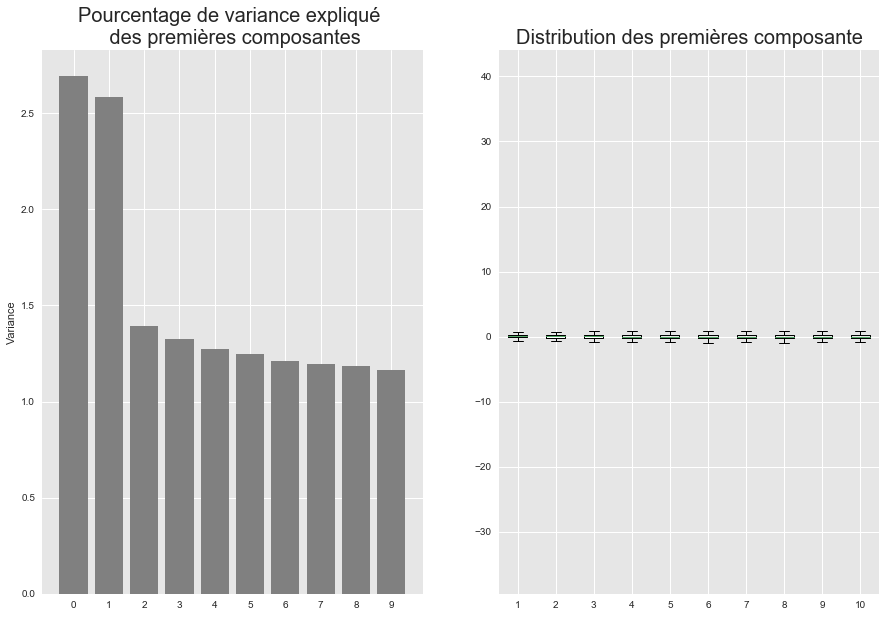

In [36]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,2,1)
ax.bar(range(10), acp3.explained_variance_ratio_[:10]*100, align='center',
        color='grey', ecolor='black')
ax.set_xticks(range(10))
ax.set_ylabel("Variance")
ax.set_title("Pourcentage de variance expliqué \n des premières composantes", fontsize=20)

ax = fig.add_subplot(1,2,2)
box=ax.boxplot(X_acp3[:,0:10])
ax.set_title("Distribution des premières composante", fontsize=20)


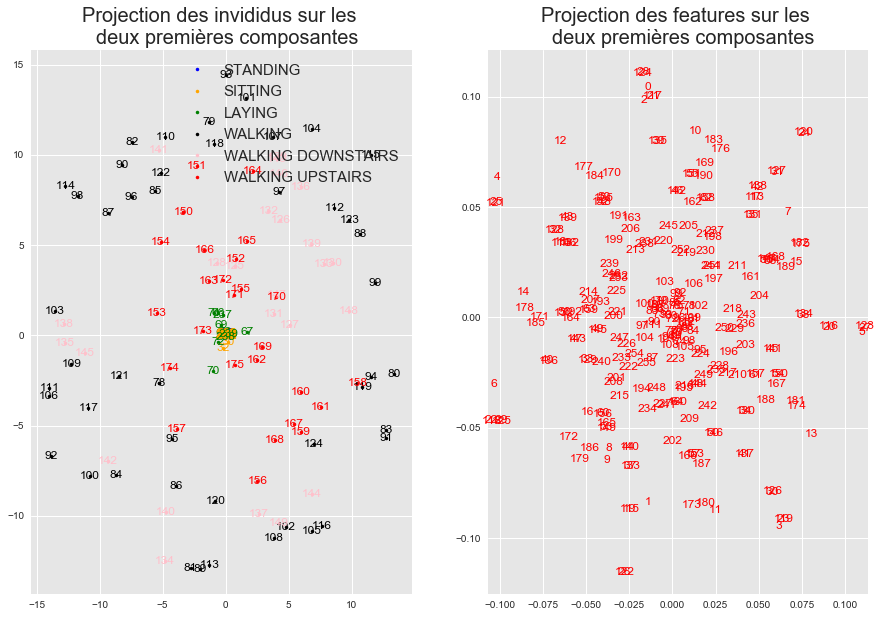

In [40]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,2,1)
labels=[]
for x,y,s, a in zip(X_acp3[:,0], X_acp3[:,1], map(str,range(240)), Y_train_label):
    ax.plot(x,y,marker=".", color=COLOR_DIC[a])
    if a!=0:
        label = ACTIVITY_DIC[a]
        ax.text(x,y,s, horizontalalignment="center", verticalalignment="center", color=COLOR_DIC[a])
        if not(label in labels):
            labels.append(label)
            ax.plot(x,y,marker=".", color=COLOR_DIC[a], label = label, linestyle="None")
plt.legend(fontsize=15)
ax.set_title("Projection des invididus sur les \n  deux premières composantes", fontsize=20)


ax = fig.add_subplot(1,2,2)
for x,y,s in zip(acp3.components_[0], acp3.components_[1], map(str,range(256))):
    ax.text(x,y,s, horizontalalignment="center", verticalalignment="center", color="red")
ax.set_xlim(acp3.components_[0].min()-0.002,acp3.components_[0].max()+0.002)
ax.set_ylim(acp3.components_[1].min()-0.01,acp3.components_[1].max()+0.01)
ax.set_title("Projection des features sur les \n  deux premières composantes", fontsize=20)


### coefficients des niveaux J=0 à  6

In [41]:
acp4 = sd.PCA()
X_acp4 = acp4.fit_transform(sp.scale(Coeff[:,:128]))

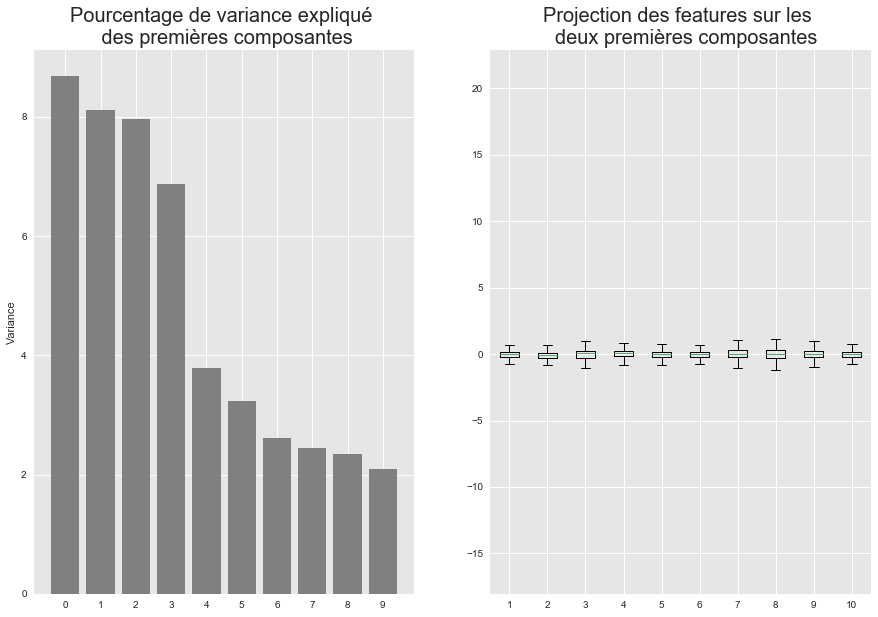

In [42]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,2,1)
ax.bar(range(10), acp4.explained_variance_ratio_[:10]*100, align='center',
        color='grey', ecolor='black')
ax.set_xticks(range(10))
ax.set_ylabel("Variance")
ax.set_title("Pourcentage de variance expliqué \n des premières composantes", fontsize=20)

ax = fig.add_subplot(1,2,2)
box=ax.boxplot(X_acp4[:,0:10])
ax.set_title("Distribution des premières composante", fontsize=20)
ax.set_title("Projection des features sur les \n  deux premières composantes", fontsize=20)


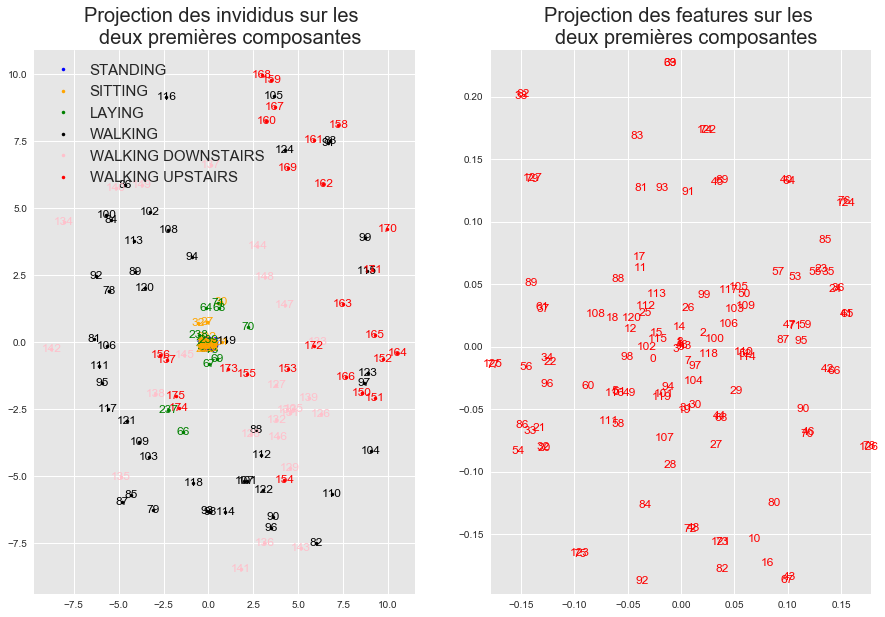

In [45]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,2,1)
labels=[]
for x,y,s, a in zip(X_acp4[:,0], X_acp4[:,1], map(str,range(240)), Y_train_label):
    ax.plot(x,y,marker=".", color=COLOR_DIC[a])
    if a!=0:
        label = ACTIVITY_DIC[a]
        ax.text(x,y,s, horizontalalignment="center", verticalalignment="center", color=COLOR_DIC[a])
        if not(label in labels):
            labels.append(label)
            ax.plot(x,y,marker=".", color=COLOR_DIC[a], label = label, linestyle="None")
ax.set_title("Projection des invididus sur les \n  deux premières composantes", fontsize=20)

plt.legend(fontsize=15)

ax = fig.add_subplot(1,2,2)
for x,y,s in zip(acp4.components_[0], acp4.components_[1], map(str,range(256))):
    ax.text(x,y,s, horizontalalignment="center", verticalalignment="center", color="red")
ax.set_xlim(acp4.components_[0].min()-0.002,acp4.components_[0].max()+0.002)
ax.set_ylim(acp4.components_[1].min()-0.01,acp4.components_[1].max()+0.01)
ax.set_title("Projection des features sur les \n  deux premières composantes", fontsize=20)


### coefficients seuillés : 


In [46]:
acp5 = sd.PCA()
X_acp5 = acp5.fit_transform(sp.scale(TCoeff))

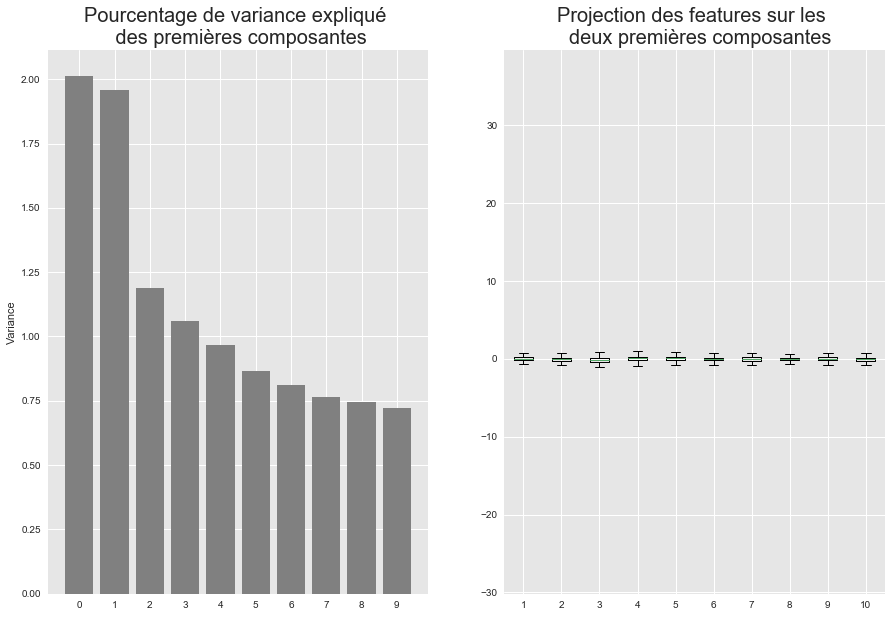

In [47]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,2,1)
ax.bar(range(10), acp5.explained_variance_ratio_[:10]*100, align='center',
        color='grey', ecolor='black')
ax.set_xticks(range(10))
ax.set_ylabel("Variance")
ax.set_title("Pourcentage de variance expliqué \n des premières composantes", fontsize=20)

ax = fig.add_subplot(1,2,2)
box=ax.boxplot(X_acp5[:,0:10])
ax.set_title("Distribution des premières composante", fontsize=20)
ax.set_title("Projection des features sur les \n  deux premières composantes", fontsize=20)

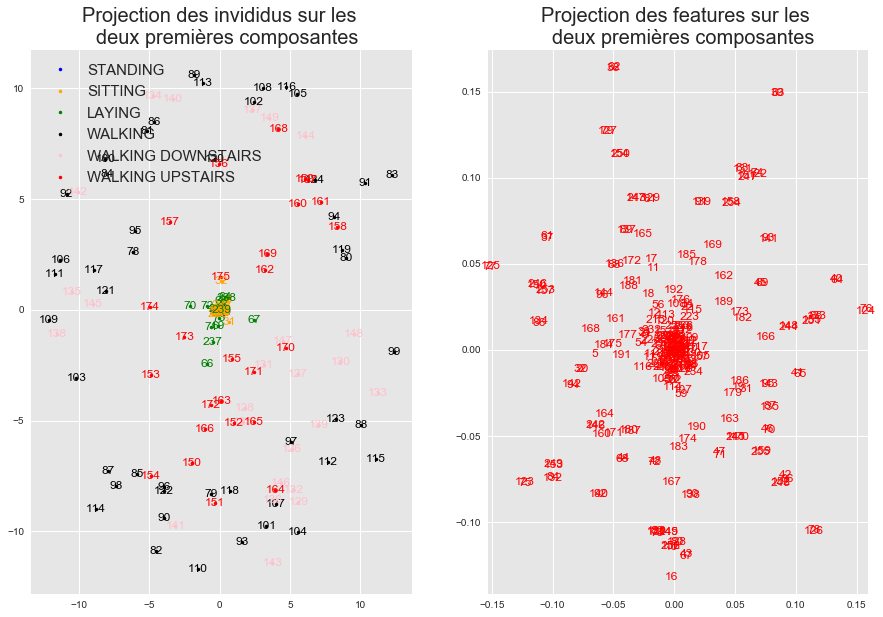

In [48]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,2,1)
labels=[]
for x,y,s, a in zip(X_acp5[:,0], X_acp5[:,1], map(str,range(240)), Y_train_label):
    ax.plot(x,y,marker=".", color=COLOR_DIC[a])
    if a!=0:
        label = ACTIVITY_DIC[a]
        ax.text(x,y,s, horizontalalignment="center", verticalalignment="center", color=COLOR_DIC[a])
        if not(label in labels):
            labels.append(label)
            ax.plot(x,y,marker=".", color=COLOR_DIC[a], label = label, linestyle="None")
ax.set_title("Projection des invididus sur les \n  deux premières composantes", fontsize=20)

plt.legend(fontsize=15)

ax = fig.add_subplot(1,2,2)
for x,y,s in zip(acp5.components_[0], acp5.components_[1], map(str,range(256))):
    ax.text(x,y,s, horizontalalignment="center", verticalalignment="center", color="red")
ax.set_xlim(acp5.components_[0].min()-0.002,acp5.components_[0].max()+0.002)
ax.set_ylim(acp5.components_[1].min()-0.01,acp5.components_[1].max()+0.01)
ax.set_title("Projection des features sur les \n  deux premières composantes", fontsize=20)


## 3 Apprentissage des signaux uni-dimensionels

La base d'apprentissage est de dimension (`N_train`, 1152)

### 3.1 Régression Logistique

La Régression Logistique est une des méthodes conduisant aux meilleurs résultats sur les vairables métier.

In [50]:
t_start = time.time()
model_lr = lm.LogisticRegression(verbose=1)
model_lr.fit(X_train_flatten, Y_train_label)
t_end = time.time()
t_learning = t_end-t_start
score = model_lr.score(X_test_flatten, Y_test_label)
print("Score With Logistic Regression on Inertial Signals = %.2f, Learning time = %.2f secondes" %(score*100, t_learning) )
lr_prediction_label = model_lr.predict(X_test_flatten)
metadata_svc = {"time_learning" : t_learning, "score" : score}
pd.DataFrame(confusion_matrix(lr_prediction_label, Y_test_label), index = ACTIVITY_DIC, columns=ACTIVITY_DIC)

[LibLinear]Score With Logistic Regression on Inertial Signals = 57.45, Learning time = 33.11 secondes


,1,2,3,4,5,6
1,120,63,97,0,1,0
2,74,218,56,23,72,27
3,92,66,103,1,2,0
4,79,32,58,397,112,0
5,131,92,106,70,345,0
6,0,0,0,0,0,510


In [54]:
t_start = time.time()
model_lr = lm.LogisticRegression(verbose=1)
model_lr.fit(Coeff_train, Y_train_label)
t_end = time.time()
t_learning = t_end-t_start
score = model_lr.score(Coeff_test, Y_test_label)
print("Score With Logistic Regression on Inertial Signals = %.2f, Learning time = %.2f secondes" %(score*100, t_learning) )
lr_prediction_label = model_lr.predict(Coeff_test)
metadata_svc = {"time_learning" : t_learning, "score" : score}
pd.DataFrame(confusion_matrix(lr_prediction_label, Y_test_label), index = ACTIVITY_DIC, columns=ACTIVITY_DIC)

[LibLinear]Score With Logistic Regression on Inertial Signals = 57.45, Learning time = 33.56 secondes


,1,2,3,4,5,6
1,120,63,97,0,1,0
2,74,218,56,23,72,27
3,92,66,103,1,2,0
4,79,32,58,397,112,0
5,131,92,106,70,345,0
6,0,0,0,0,0,510


In [56]:
r,c=Coeff_train.shape
Y_train_label.shape

(7352,)

In [58]:
t_start = time.time()
model_lr = lm.LogisticRegression(verbose=1)
model_lr.fit(Coeff_train[:,:round(c/2)], Y_train_label)
t_end = time.time()
t_learning = t_end-t_start
score = model_lr.score(Coeff_test[:,:round(c/2)], Y_test_label)
print("Score With Logistic Regression on Inertial Signals = %.2f, Learning time = %.2f secondes" %(score*100, t_learning) )
lr_prediction_label = model_lr.predict(Coeff_test[:,:round(c/2)])
metadata_svc = {"time_learning" : t_learning, "score" : score}
pd.DataFrame(confusion_matrix(lr_prediction_label, Y_test_label), index = ACTIVITY_DIC, columns=ACTIVITY_DIC)

[LibLinear]Score With Logistic Regression on Inertial Signals = 58.03, Learning time = 18.34 secondes


,1,2,3,4,5,6
1,120,63,85,0,6,0
2,91,230,59,23,72,27
3,75,63,113,1,2,0
4,76,33,61,396,111,0
5,134,82,102,71,341,0
6,0,0,0,0,0,510


In [59]:
t_start = time.time()
model_lr = lm.LogisticRegression(verbose=1)
model_lr.fit(Coeff_train[:,round(c/2):], Y_train_label)
t_end = time.time()
t_learning = t_end-t_start
score = model_lr.score(Coeff_test[:,round(c/2):], Y_test_label)
print("Score With Logistic Regression on Inertial Signals = %.2f, Learning time = %.2f secondes" %(score*100, t_learning) )
lr_prediction_label = model_lr.predict(Coeff_test[:,round(c/2):])
metadata_svc = {"time_learning" : t_learning, "score" : score}
pd.DataFrame(confusion_matrix(lr_prediction_label, Y_test_label), index = ACTIVITY_DIC, columns=ACTIVITY_DIC)

[LibLinear]Score With Logistic Regression on Inertial Signals = 29.96, Learning time = 5.04 secondes


,1,2,3,4,5,6
1,140,114,115,2,2,0
2,69,94,77,0,2,1
3,117,77,95,0,0,0
4,11,6,1,0,0,0
5,69,70,53,23,28,10
6,90,110,79,466,500,526


**Q** Que dire de la performance?

**TODO?** Tester d'autre méthode (SVM, XGBOOST?)

### 3.2 Perceptron multicouche

Un réseau de neurones classique est appris sur les données au même format que précédemment.

**Q** Expliciter les choix des paramètres et donc la structure du réseau.

In [62]:
epochs = 10
batch_size = 32
n_hidden = 32

n_features = X_train_flatten.shape[1]
n_classes=6


model_base_mlp_u =km.Sequential()
model_base_mlp_u.add(kl.Dense(n_hidden, input_shape=(n_features,),  activation = "relu"))
model_base_mlp_u.add(kl.Dropout(0.5))
model_base_mlp_u.add(kl.Dense(n_classes, activation='softmax'))
model_base_mlp_u.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model_base_mlp_u.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                36896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 198       
Total params: 37,094
Trainable params: 37,094
Non-trainable params: 0
_________________________________________________________________


In [63]:
t_start = time.time()
model_base_mlp_u.fit(X_train_flatten,  Y_train_dummies, batch_size=batch_size, validation_data=(X_test_flatten, Y_test_dummies), epochs=epochs)
t_end = time.time()
t_learning = t_end-t_start

score = model_base_mlp_u.evaluate(X_test_flatten, Y_test_dummies)[1] 
print("Score With Simple MLP on Inertial Signals = %.2f, Learning time = %.2f secondes" %(score*100, t_learning) )
metadata_mlp_u = {"time_learning" : t_learning, "score" : score}
base_mlp_u_prediction = model_base_mlp_u.predict(X_test_flatten)

my_confusion_matrix(Y_test_dummies, base_mlp_u_prediction)

Train on 7352 samples, validate on 2947 samples
Epoch 1/10
7352/7352 [==============================] - 1s - loss: 1.1312 - acc: 0.5472 - val_loss: 0.9903 - val_acc: 0.6878
Epoch 2/10
7352/7352 [==============================] - 0s - loss: 0.9013 - acc: 0.6602 - val_loss: 0.8665 - val_acc: 0.7482
Epoch 3/10
7352/7352 [==============================] - 0s - loss: 0.8177 - acc: 0.6964 - val_loss: 0.7730 - val_acc: 0.7896
Epoch 4/10
7352/7352 [==============================] - 0s - loss: 0.7698 - acc: 0.7156 - val_loss: 0.7306 - val_acc: 0.7757
Epoch 5/10
7352/7352 [==============================] - 0s - loss: 0.7097 - acc: 0.7364 - val_loss: 0.7123 - val_acc: 0.7967
Epoch 6/10
7352/7352 [==============================] - 0s - loss: 0.6768 - acc: 0.7484 - val_loss: 0.6895 - val_acc: 0.7950
Epoch 7/10
7352/7352 [==============================] - 0s - loss: 0.6758 - acc: 0.7467 - val_loss: 0.6730 - val_acc: 0.8025
Epoch 8/10
7352/7352 [==============================] - 0s - loss: 0.6561 - a

NameError: name 'my_confusion_matrix' is not defined

** Q ** : Que conclure sur ces résultats en terme de performance, de temps d'apprentissage? Comparer avec la regression logistique?

** Exo ** : Quel est l'influence de l'ajout de nouvelle couche? Supression du Dropout? ...

## 4 Apprentissage des signaux multidimensionnels
Les différents signaux ne sont pas concaténées en un seul signal mais pris en compte parallèlement.

### 4.1 Perceptron multichouche
**Q** Expliciter les choix des paramètres et donc la structure du réseau.

In [ ]:
n_hidden = 32

timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = 6

model_base_mlp =km.Sequential()
model_base_mlp.add(kl.Dense(n_hidden, input_shape=(timesteps, input_dim),  activation = "relu"))
model_base_mlp.add(kl.Reshape((timesteps*n_hidden,) , input_shape= (timesteps, n_hidden)  ))
model_base_mlp.add(kl.Dense(n_classes, activation='softmax'))

model_base_mlp.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

t_start = time.time()
model_base_mlp.fit(X_train,  Y_train_dummies, batch_size=batch_size, validation_data=(X_test, Y_test_dummies), epochs=epochs)
t_end = time.time()
t_learning = t_end-t_start

score = model_base_mlp.evaluate(X_test, Y_test_dummies)[1] 
print("Score With Simple MLP on Multidimensional Inertial Signals = %.2f, Learning time = %.2f secondes" %(score*100, t_learning) )
metadata_mlp = {"time_learning" : t_learning, "score" : score}
base_mlp_prediction = model_base_mlp.predict(X_test)

my_confusion_matrix(Y_test_dummies, base_mlp_prediction)

In [ ]:
model_base_mlp.summary()

### 4.2 *Long Short Time Memory (LSTM)*
Test d'un réseau avec couche LSTM avec l'idée d'appréhender la structure temporelle des données.

In [1]:
n_hidden = 32
#default stateful = False

timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = 6

batch_size=64
#else:
model_base_lstm =km.Sequential()
model_base_lstm.add(kl.LSTM(n_hidden, input_shape=(timesteps, input_dim)))
model_base_lstm.add(kl.Dense(n_classes, activation='softmax'))

model_base_lstm.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model_base_lstm.summary()

NameError: name 'X_train' is not defined

In [ ]:
# Default shuffle = True Meilleur avec Shuffle m True
t_start = time.time()
model_base_lstm.fit(X_train,  Y_train_dummies, batch_size=batch_size, validation_data=(X_test, Y_test_dummies), epochs=epochs, shuffle=False)
t_end = time.time()
t_learning = t_end-t_start

score = model_base_lstm.evaluate(X_test, Y_test_dummies)[1] 
print("Score With Simple MLP on Multidimensional Inertial Signals = %.2f, Learning time = %.2f secondes" %(score*100, t_learning) )
metadata_lstm = {"time_learning" : t_learning, "score" : score}
base_lstm_prediction = model_base_lstm.predict(X_test)

my_confusion_matrix(Y_test_dummies, base_lstm_prediction)

### 3.3 Réseau avec couche convolutionelle 1D (*ConvNet*)

In [ ]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = 6

#else:
model_base_conv_1D =km.Sequential()
model_base_conv_1D.add(kl.Conv1D(32, 9, activation='relu', input_shape=(timesteps, input_dim)))
model_base_conv_1D.add(kl.MaxPooling1D(pool_size=3))
model_base_conv_1D.add(kl.Flatten())
model_base_conv_1D.add(kl.Dense(n_classes, activation='softmax'))
model_base_conv_1D.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

t_start = time.time()
model_base_conv_1D.fit(X_train,  Y_train_dummies, batch_size=batch_size, validation_data=(X_test, Y_test_dummies), epochs=epochs)
t_end = time.time()
t_learning = t_end-t_start

score = model_base_conv_1D.evaluate(X_test, Y_test_dummies)[1] 
print("Score With Conv on Multidimensional Inertial Signals = %.2f, Learning time = %.2f secondes" %(score*100, t_learning) )
metadata_conv = {"time_learning" : t_learning, "score" : score}
base_conv_1D_prediction = model_base_conv_1D.predict(X_test)

my_confusion_matrix(Y_test_dummies, base_conv_1D_prediction)

In [ ]:
model_base_conv_1D.summary()

### 4.3 Réseau avec couche convolutionelle 2D (*ConvNet*)

In [ ]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = 6

X_train_conv = X_train.reshape(N_train, timesteps, input_dim, 1)
X_test_conv = X_test.reshape(N_test, timesteps, input_dim, 1)

#else:
model_base_conv_2D =km.Sequential()
model_base_conv_2D.add(kl.Conv2D(32, (3, 9), activation='relu', input_shape=(timesteps, input_dim, 1)))
model_base_conv_2D.add(kl.MaxPooling2D(pool_size=(2, 1)))
model_base_conv_2D.add(kl.Flatten())
model_base_conv_2D.add(kl.Dense(n_classes, activation='softmax'))
model_base_conv_2D.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

t_start = time.time()
model_base_conv_2D.fit(X_train_conv,  Y_train_dummies, batch_size=batch_size, validation_data=(X_test_conv, Y_test_dummies), epochs=epochs)
t_end = time.time()
t_learning = t_end-t_start

score = model_base_conv_2D.evaluate(X_test_conv, Y_test_dummies)[1] 
print("Score With Conv on Multidimensional Inertial Signals = %.2f, Learning time = %.2f secondes" %(score*100, t_learning) )
metadata_conv = {"time_learning" : t_learning, "score" : score}
base_conv_2D_prediction = model_base_conv_2D.predict(X_test_conv)

my_confusion_matrix(Y_test_dummies, base_conv_2D_prediction)

In [ ]:
model_base_conv_2D.summary()

**Objectif** trouver la meilleure architecture.

**Attention au sur-apprentissage** A force de rechercher la meilleure architecture en minimisant l'erreur sur l'échantillon test, celle finalement trouvée peut y être très adaptée réduisant ainsi la capacité de généralisation. Il serait prudent de multiplier le découpage de l'échantillon par validation croisée *Monte Carlo*.